### Author: Navtegh Singh Gill        
Date: February 15th, 2025
Internship Technical Challenge: Deep Learning for EEG Signal Modeling 

In [51]:
import os
import numpy as np
import mne
import matplotlib
import matplotlib.pyplot as plt
from copy import deepcopy

In [100]:

# Task 1 -> A target appears on either the left or the right side of the screen. The subject opens and closes the corresponding fist until the target disappears. Then the subject relaxes.
# Task 2 -> A target appears on either the left or the right side of the screen. The subject imagines opening and closing the corresponding fist until the target disappears. Then the subject relaxes.
# Task 3 -> A target appears on either the top or the bottom of the screen. The subject opens and closes either both fists (if the target is on top) or both feet (if the target is on the bottom) until the target disappears. Then the subject relaxes.
# Task 4 -> A target appears on either the top or the bottom of the screen. The subject imagines opening and closing either both fists (if the target is on top) or both feet (if the target is on the bottom) until the target disappears. Then the subject relaxes.

# Each annotation includes one of three codes (T0, T1, or T2):

# T0 corresponds to rest
# T1 corresponds to onset of motion (real or imagined) of
# the left fist (in runs 3, 4, 7, 8, 11, and 12)
# both fists (in runs 5, 6, 9, 10, 13, and 14)
# T2 corresponds to onset of motion (real or imagined) of
# the right fist (in runs 3, 4, 7, 8, 11, and 12)
# both feet (in runs 5, 6, 9, 10, 13, and 14)


# Task 1 -> [3,7,11]
# Task 2 -> [4,8,12]
# Task 3 -> [5,9,13]
# Task 4 -> [6,10,14]


In [235]:
total_subject=109
dataset_path = [mne.datasets.eegbci.load_data(idx,[4,8,11],"./Dataset") # Task can be changed using any of the lists above
    for idx in range(1, (total_subject - 108) + 1)] # (total - x) subjects, we take 1 and 36 due to computational restrictions
dataset_path = np.concatenate(dataset_path) # Concatenating dataset paths

In [236]:
list_subj = [mne.io.read_raw_edf(path,preload=True,stim_channel='auto',verbose='WARNING',)
        for path in dataset_path] # Reading subject files

In [237]:
raw = mne.concatenate_raws(list_subj) # Concatenating subject files
mne.datasets.eegbci.standardize(raw) # Standardizing channels and names
montage = mne.channels.make_standard_montage("standard_1005")
raw.set_montage(montage) # Setting the montage for EEG channels

Measurement date,"August 12, 2009 16:15:00 GMT"
Experimenter,Unknown
Participant,X
Digitized points,67 points
Good channels,64 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,160.00 Hz
Highpass,0.00 Hz
Lowpass,80.00 Hz


In [238]:
eeg_channel_inds = mne.pick_types(raw.info,meg=False,eeg=True,stim=False,eog=False,exclude='bads') # Picking EEG channels

In [239]:
events, event_id = mne.events_from_annotations(raw) # Extracing events and event ids

Used Annotations descriptions: ['T0', 'T1', 'T2']


In [ ]:
print(raw.plot(duration=30, n_channels=len(raw.ch_names),scalings={'eeg':200e-6}, remove_dc=False))

Using matplotlib as 2D backend.
Figure(800x800)


In [241]:
raw.set_eeg_reference(ref_channels="average") # setting a virtual reference that is the average of all channels

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


Measurement date,"August 12, 2009 16:15:00 GMT"
Experimenter,Unknown
Participant,X
Digitized points,67 points
Good channels,64 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,160.00 Hz
Highpass,0.00 Hz
Lowpass,80.00 Hz


In [242]:
power_line_freq = 60 # USA power line frequency

In [243]:
raw_notch = raw.copy().notch_filter(freqs=(power_line_freq,)) # power line noise removal

Filtering raw data in 3 contiguous segments
Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 60.90 Hz)
- Filter length: 1057 samples (6.606 s)

Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 12.800 (s)


/Users/navtegh/miniconda/envs/eeg/lib/python3.11/site-packages/mne/viz/utils.py:165: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


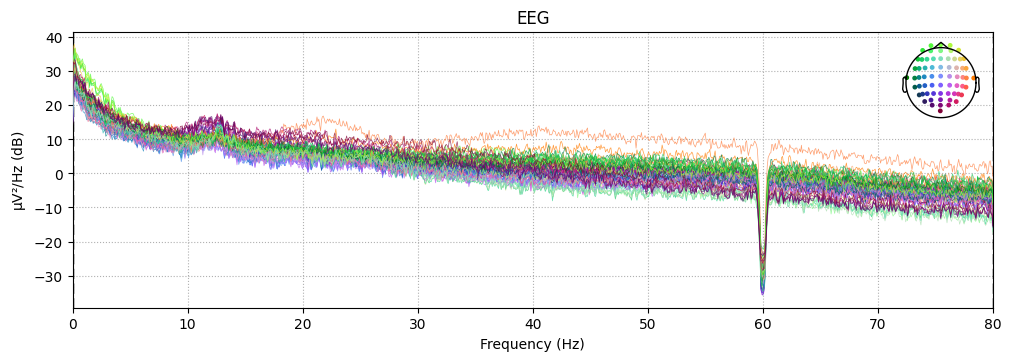

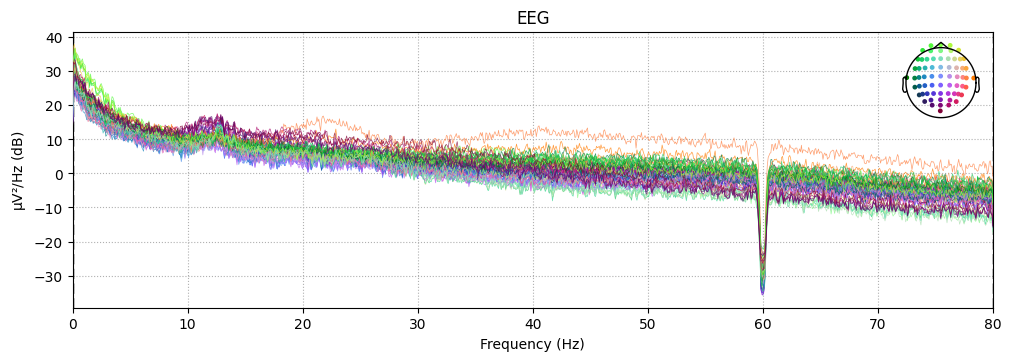

In [244]:
samp_freq=160
power_line_freq = 60
raw_notch.plot_psd(tmax=np.inf, fmax=samp_freq/2)  # after notch filtering

Filtering raw data in 3 contiguous segments
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 529 samples (3.306 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


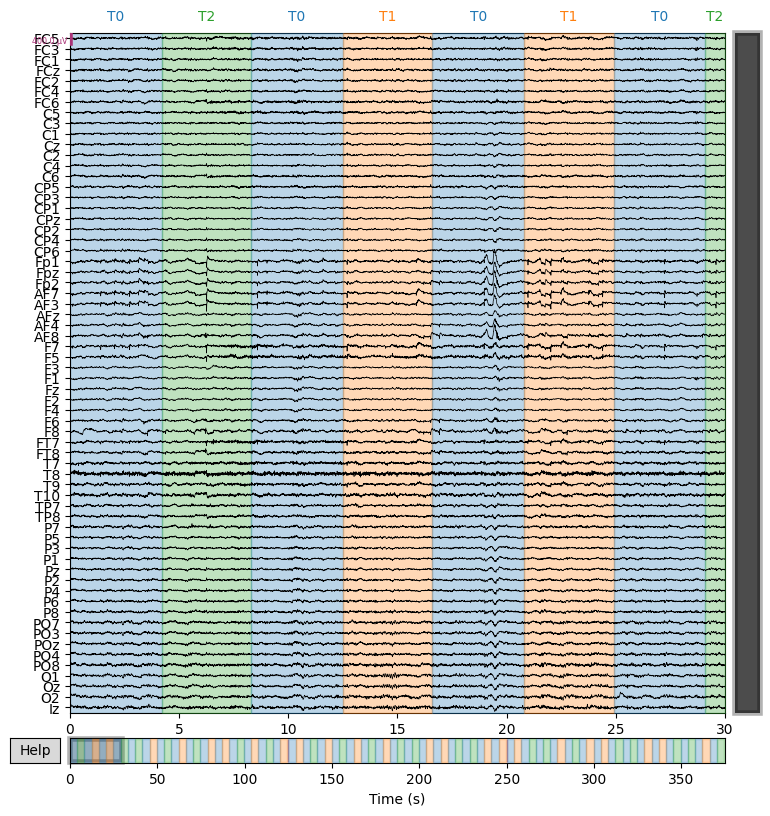

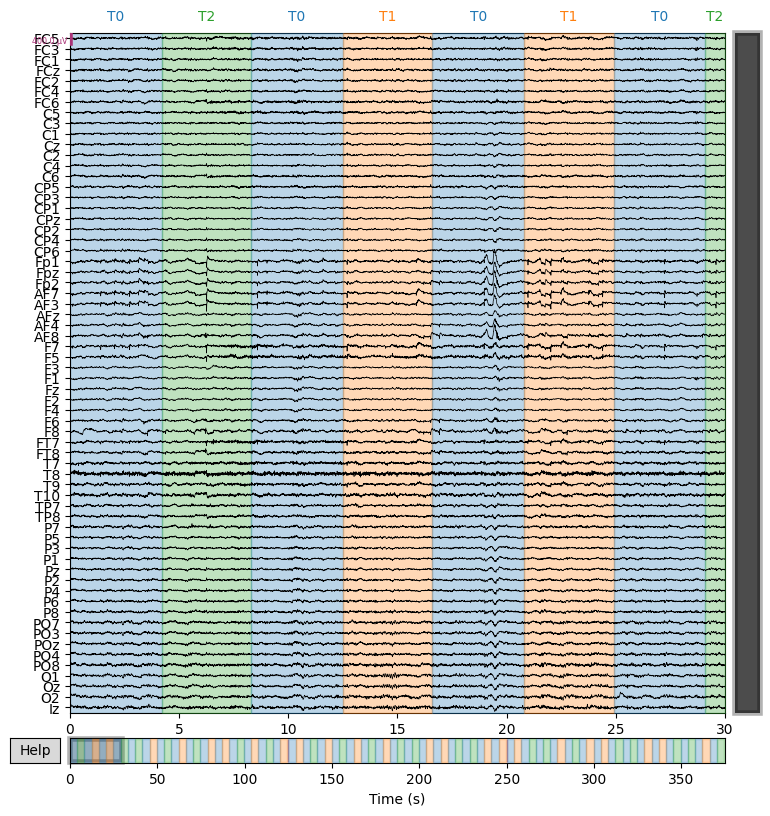

In [245]:
cutoff = 1. # Hz, to remove slow drifts
raw_hp = raw_notch.copy().filter(l_freq=cutoff, h_freq=None)
raw_hp.plot(duration=30, n_channels=len(raw.ch_names), scalings={'eeg':200e-6}, remove_dc=False)

Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 529 samples (3.306 s)



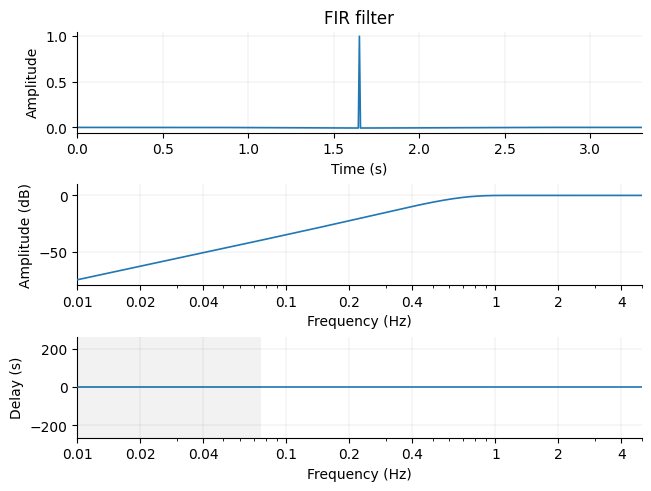

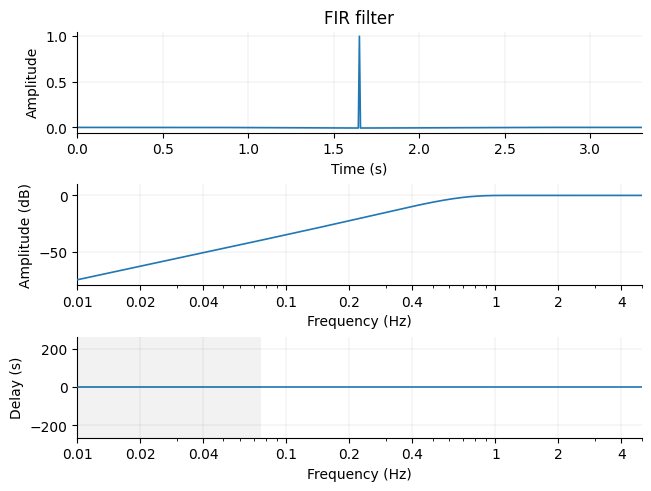

In [246]:
filter_params = mne.filter.create_filter(raw.get_data(),
                                         raw.info['sfreq'],
                                         l_freq=cutoff,
                                         h_freq=None)
mne.viz.plot_filter(filter_params, raw.info['sfreq'], flim=(0.01, 5))

In [247]:
raw=raw_hp

In [248]:
EEG_CHANNEL = int(len(eeg_channel_inds))

epoched = mne.Epochs( # creating epochs of the events
    raw,
    events,
    dict(left=2, right=3),
    tmin=-1,      # starting 1 second before the execution of the movement
    tmax=4.0,     # ending at 4 second, i.e total duration of 4 seconds ()
    proj=False,
    picks=eeg_channel_inds,
    baseline=None,
    preload=True
)
epoched._data=mne.decoding.Scaler(scalings='mean').fit_transform(epoched.get_data()) # Normalizing data

Not setting metadata
45 matching events found
No baseline correction applied
Using data from preloaded Raw for 45 events and 801 original time points ...
0 bad epochs dropped


/var/folders/yp/vbxqsj792y10fn807d171gyc0000gn/T/ipykernel_38748/2022190136.py:14: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epoched._data=mne.decoding.Scaler(scalings='mean').fit_transform(epoched.get_data()) # Normalizing data


In [249]:

X = (epoched.get_data()).astype(np.float32)
y = (epoched.events[:, 2] - 2).astype(np.int64)


CLASSES = ["left", "right"]  # Can be changed to ["Fist", "Feet"] for task 3,4

/var/folders/yp/vbxqsj792y10fn807d171gyc0000gn/T/ipykernel_38748/3221279108.py:1: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  X = (epoched.get_data()).astype(np.float32)


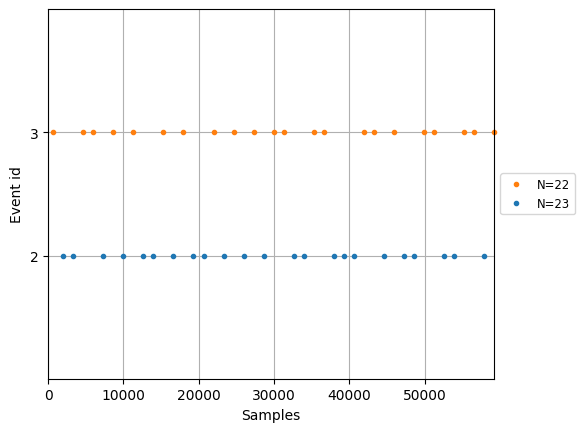

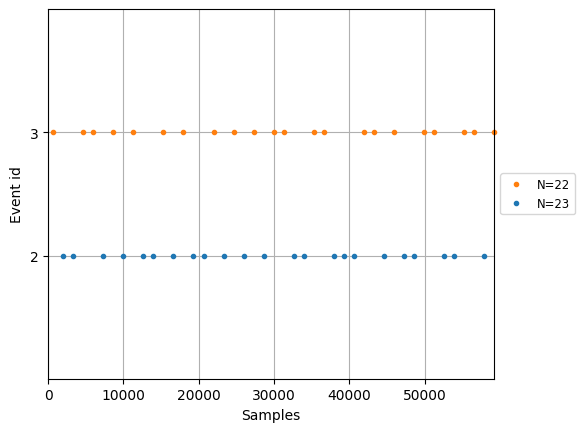

In [250]:
mne.viz.plot_events(epoched.events) # Plotting events

In [251]:
del raw, events, epoched, dataset_path, raw_hp, list_subj # Deleting variables to save memory

In [252]:
from sklearn.model_selection import train_test_split 

In [253]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1) # splitting dataset -> train, test: 80:20
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1) # splitting training dataset -> train, val: 80:20

In [254]:
X_train=np.transpose(X_train, (0, 2, 1)) # batch size x data points (Samp_Freq x timeofevent) x number_of_channels
X_val=np.transpose(X_val, (0, 2, 1))
X_test=np.transpose(X_test, (0, 2, 1))

In [255]:
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dropout, Flatten, Dense, Input, GRU, LSTM
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import cohen_kappa_score, f1_score, precision_score, recall_score, confusion_matrix
import seaborn as sns

# EEGnet

In [256]:
def build_eegnet(input_shape):
    inputs = Input(shape=input_shape)
    x = Conv1D(filters=16, kernel_size=3, activation='relu', padding='same')(inputs)
    x = MaxPooling1D(pool_size=2)(x)
    x = Dropout(0.3)(x)
    
    x = Conv1D(filters=32, kernel_size=3, activation='relu', padding='same')(x)
    x = MaxPooling1D(pool_size=2)(x)
    x = Dropout(0.3)(x)
    
    x = Flatten()(x)
    x = Dense(32, activation='relu')(x)
    x = Dropout(0.5)(x)
    
    outputs = Dense(1, activation='sigmoid')(x)
    
    return Model(inputs, outputs)

In [257]:
def build_cnn(input_shape):
    model = Sequential([
        Conv1D(16, kernel_size=12, activation='relu', input_shape=input_shape),
        MaxPooling1D(pool_size=2),
        Dropout(0.35),
        Conv1D(32, kernel_size=6, activation='relu'),
        MaxPooling1D(pool_size=2),
        Dropout(0.35),
        Flatten(),
        Dense(32, activation='relu'),
        Dropout(0.45),
        Dense(1, activation='sigmoid')
    ])
    return model

# CNN with Gated Recurrent Unit

In [258]:
# Function to define the CNN-GRU model
def build_cnn_gru(input_shape):
    model = Sequential([
        Conv1D(16, kernel_size=12, activation='relu', input_shape=input_shape),
        MaxPooling1D(pool_size=2),
        Dropout(0.35),
        Conv1D(32, kernel_size=6, activation='relu'),
        MaxPooling1D(pool_size=2),
        Dropout(0.35),
        GRU(32, recurrent_dropout=0.25, return_sequences=True),
        Dropout(0.3),
        Dropout(0.2),
        Flatten(),
        Dense(1, activation='sigmoid')
    ])
    return model

# LSTM

In [259]:
# Function to define the LSTM model
def build_lstm(input_shape):
    model = Sequential([
    LSTM(32, input_shape=input_shape, recurrent_dropout=0.3, return_sequences=True),
    Dropout(0.3),
    LSTM(16, recurrent_dropout=0.3, return_sequences=True),
    Flatten(),
    Dense(1, activation='sigmoid')])
    return model


In [260]:
# Function to train and evaluate a model
def train_and_evaluate(model, X_train, y_train, X_val, y_val, X_test, y_test, epochs=50, batch_size=32, learning_rate=0.001):
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
    
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, y_val), callbacks=[early_stopping])
    
    y_pred_probs = model.predict(X_test)
    y_pred_classes = (y_pred_probs > 0.5).astype(int)
    
    print(f"Kappa Score: {cohen_kappa_score(y_test, y_pred_classes)}")
    print(f"F1 Score: {f1_score(y_test, y_pred_classes)}")
    print(f"Precision: {precision_score(y_test, y_pred_classes)}")
    print(f"Recall: {recall_score(y_test, y_pred_classes)}")
    
    # Compute confusion matrix
    cm = confusion_matrix(y_test, y_pred_classes)
    plt.figure(figsize=(6,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()
    
    test_loss, test_acc = model.evaluate(X_test, y_test)
    print(f"Test Loss: {test_loss}")
    print(f"Test Accuracy: {test_acc}")
    
    
    return model


Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 811ms/step - accuracy: 0.7143 - loss: 0.7147 - val_accuracy: 0.7500 - val_loss: 0.5539
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.4643 - loss: 0.9785 - val_accuracy: 0.3750 - val_loss: 1.0489
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.5000 - loss: 1.5535 - val_accuracy: 0.3750 - val_loss: 0.7846
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.6071 - loss: 0.8340 - val_accuracy: 0.7500 - val_loss: 0.5915
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.7143 - loss: 0.4631 - val_accuracy: 0.6250 - val_loss: 0.5991
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.5357 - loss: 0.7465 - val_accuracy: 0.6250 - val_loss: 0.5805
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.7857 - loss: 0.5002 - val_accuracy: 0.6250 - val_loss: 0.6525
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.8929 - loss: 0.3986 - val_accuracy: 0.3750 - val_loss: 0.8274

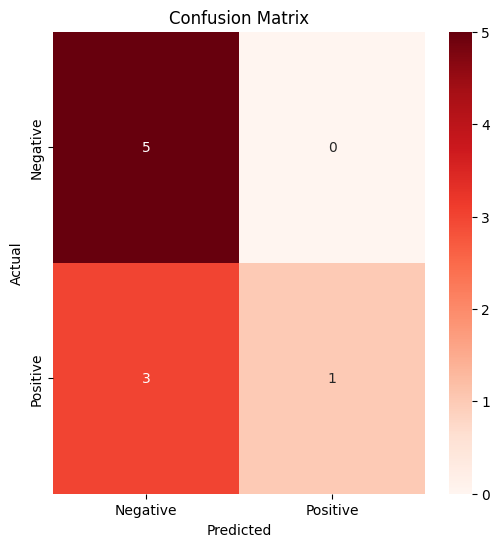

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.6667 - loss: 0.6875
Test Loss: 0.687472939491272
Test Accuracy: 0.6666666865348816


In [261]:
# Train and evaluate EEGNet
eegnet_model = build_eegnet(input_shape=(X_train.shape[1], X_train.shape[2]))
eegnet_model = train_and_evaluate(eegnet_model, X_train, y_train, X_val, y_val, X_test, y_test)

In [262]:
eegnet_model.summary()

Model: "functional_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_17 (InputLayer)     │ (None, 801, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_26 (Conv1D)              │ (None, 801, 16)        │         3,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_26 (MaxPooling1D) │ (None, 400, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_47 (Dropout)            │ (None, 400, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_27 (Conv1D)              │ (None, 400, 32)        │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_27 (MaxPooling1D) │ (None, 200, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_48 (Dropout)            │ (None, 200, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_17 (Flatten)            │ (None, 6400)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 32)             │       204,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_49 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 628,565 (2.40 MB)

 Trainable params: 209,521 (818.44 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 419,044 (1.60 MB)

Epoch 1/50


/Users/navtegh/miniconda/envs/eeg/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 667ms/step - accuracy: 0.3929 - loss: 1.2175 - val_accuracy: 0.6250 - val_loss: 0.6351
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.5714 - loss: 0.7191 - val_accuracy: 0.3750 - val_loss: 0.7519
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.7500 - loss: 0.5795 - val_accuracy: 0.5000 - val_loss: 0.7563
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.7857 - loss: 0.5893 - val_accuracy: 0.6250 - val_loss: 0.6577
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.7857 - loss: 0.4579 - val_accuracy: 0.7500 - val_loss: 0.5637
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.6786 - loss: 0.6088 - val_accuracy: 0.7500 - val_loss: 0.5464
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.7143 - loss: 0.4238 - val_accuracy: 0.6250 - val_loss: 0.6036
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.7500 - loss: 0.3716 - val_accuracy: 0.5000 - val_loss: 0.6882
Epoch 9/50

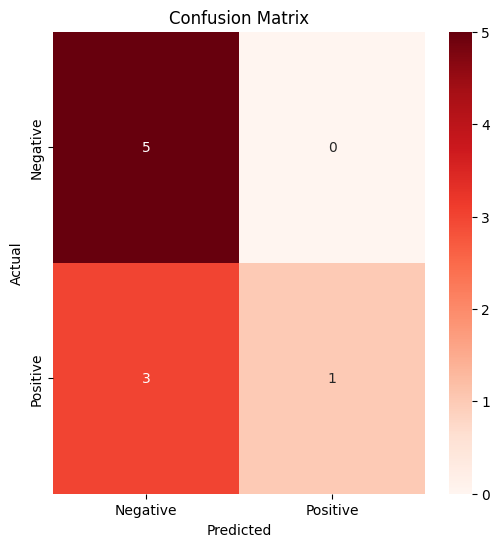

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.6667 - loss: 0.6810
Test Loss: 0.6810001730918884
Test Accuracy: 0.6666666865348816


In [263]:
# Train and evaluate EEGNet
cnn_model = build_cnn(input_shape=(X_train.shape[1], X_train.shape[2]))
cnn_model = train_and_evaluate(cnn_model, X_train, y_train, X_val, y_val, X_test, y_test)

In [264]:
cnn_model.summary()

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_28 (Conv1D)              │ (None, 790, 16)        │        12,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_28 (MaxPooling1D) │ (None, 395, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_50 (Dropout)            │ (None, 395, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_29 (Conv1D)              │ (None, 390, 32)        │         3,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_29 (MaxPooling1D) │ (None, 195, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_51 (Dropout)            │ (None, 195, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_18 (Flatten)            │ (None, 6240)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 32)             │       199,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_52 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 645,461 (2.46 MB)

 Trainable params: 215,153 (840.44 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 430,308 (1.64 MB)

Epoch 1/35


/Users/navtegh/miniconda/envs/eeg/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.5000 - loss: 0.8695 - val_accuracy: 0.6250 - val_loss: 0.7196
Epoch 2/35
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.5357 - loss: 0.7281 - val_accuracy: 0.6250 - val_loss: 0.7240
Epoch 3/35
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.6071 - loss: 0.6106 - val_accuracy: 0.5000 - val_loss: 0.7450
Epoch 4/35
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.4643 - loss: 0.7348 - val_accuracy: 0.5000 - val_loss: 0.7693
Epoch 5/35
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.6429 - loss: 0.6078 - val_accuracy: 0.5000 - val_loss: 0.7915
Epoch 6/35
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.7500 - loss: 0.5328 - val_accuracy: 0.5000 - val_loss: 0.7872
Epoch 7/35
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.7143 - loss: 0.5610 - val_accuracy: 0.5000 - val_loss: 0.7690
Epoch 8/35
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.7857 - loss: 0.4467 - val_accuracy: 0.5000 - val_loss: 0.7643
Epoch 9/35
1

/Users/navtegh/miniconda/envs/eeg/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


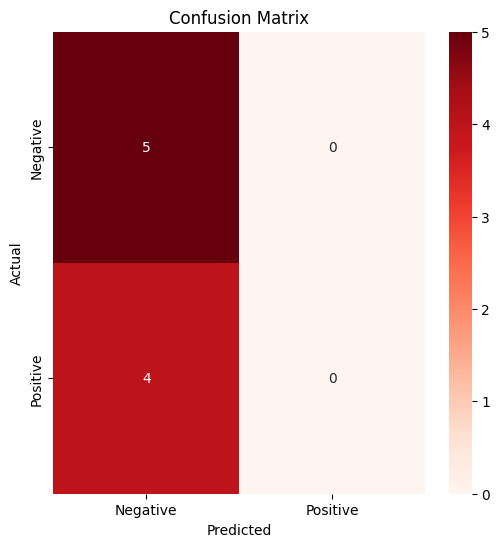

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5556 - loss: 0.6509
Test Loss: 0.65092933177948
Test Accuracy: 0.5555555820465088


In [265]:
# Train and evaluate CNN-GRU
cnn_gru_model = build_cnn_gru(input_shape=(X_train.shape[1], X_train.shape[2]))
cnn_gru_model = train_and_evaluate(cnn_gru_model, X_train, y_train, X_val, y_val, X_test, y_test, epochs=35, learning_rate=0.001)


In [266]:
cnn_gru_model.summary()

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_30 (Conv1D)              │ (None, 790, 16)        │        12,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_30 (MaxPooling1D) │ (None, 395, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_53 (Dropout)            │ (None, 395, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_31 (Conv1D)              │ (None, 390, 32)        │         3,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_31 (MaxPooling1D) │ (None, 195, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_54 (Dropout)            │ (None, 195, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_4 (GRU)                     │ (None, 195, 32)        │         6,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_55 (Dropout)            │ (None, 195, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_56 (Dropout)            │ (None, 195, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_19 (Flatten)            │ (None, 6240)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 1)              │         6,241 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 83,957 (327.96 KB)

 Trainable params: 27,985 (109.32 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 55,972 (218.64 KB)

Epoch 1/35


/Users/navtegh/miniconda/envs/eeg/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.5714 - loss: 0.6726 - val_accuracy: 0.2500 - val_loss: 0.7898
Epoch 2/35
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step - accuracy: 0.7143 - loss: 0.6547 - val_accuracy: 0.2500 - val_loss: 0.7928
Epoch 3/35
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step - accuracy: 0.7143 - loss: 0.6519 - val_accuracy: 0.2500 - val_loss: 0.7956
Epoch 4/35
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step - accuracy: 0.7857 - loss: 0.6354 - val_accuracy: 0.2500 - val_loss: 0.7981
Epoch 5/35
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step - accuracy: 0.8214 - loss: 0.6053 - val_accuracy: 0.2500 - val_loss: 0.8007
Epoch 6/35
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step - accuracy: 0.8214 - loss: 0.5948 - val_accuracy: 0.2500 - val_loss: 0.8033
Epoch 7/35
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step - accuracy: 0.7857 - loss: 0.5863 - val_accuracy: 0.2500 - val_loss: 0.8056
Epoch 8/35
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step - accuracy: 0.7500 - loss: 0.5749 - val_accuracy: 0.2500 - val_loss: 0.8080
Epoch 

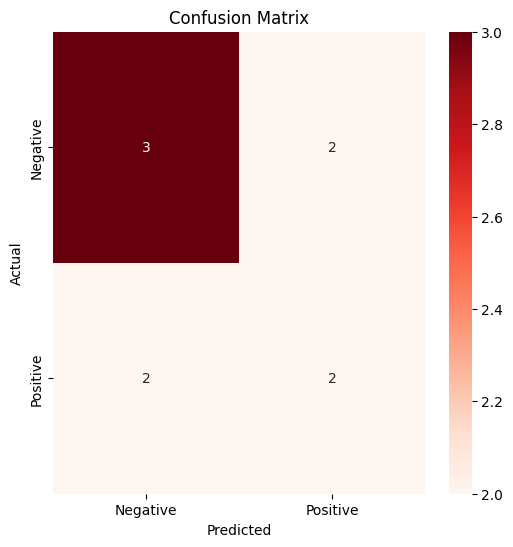

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.5556 - loss: 0.6711
Test Loss: 0.6710521578788757
Test Accuracy: 0.5555555820465088


In [267]:
# Train and evaluate LSTM
lstm_model = build_lstm(input_shape=(X_train.shape[1], X_train.shape[2]))
lstm_model = train_and_evaluate(lstm_model, X_train, y_train, X_val, y_val, X_test, y_test, epochs=35, learning_rate=0.0001)

In [268]:
lstm_model.summary()

Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_8 (LSTM)                   │ (None, 801, 32)        │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_57 (Dropout)            │ (None, 801, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ (None, 801, 16)        │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_20 (Flatten)            │ (None, 12816)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 1)              │        12,817 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 85,109 (332.46 KB)

 Trainable params: 28,369 (110.82 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 56,740 (221.64 KB)

# CNN Transformer (Inspired by ViT)

In [269]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torch.nn.functional as F
from torch.autograd import Variable

import lightning as L
from lightning.pytorch import Trainer, seed_everything
from lightning.pytorch.loggers import TensorBoardLogger, CSVLogger
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from lightning.pytorch.callbacks import LearningRateMonitor, ModelCheckpoint

from torchmetrics.classification import Accuracy


In [270]:
class EEGDataset(data.Dataset):
    def __init__(self, x, y=None, inference=False):
        super().__init__()

        N_SAMPLE = x.shape[0]
        val_idx = int(0.9 * N_SAMPLE)
        train_idx = int(0.81 * N_SAMPLE)

        if not inference:
            self.train_ds = {
                'x': x[:train_idx],
                'y': y[:train_idx],
            }
            self.val_ds = {
                'x': x[train_idx:val_idx],
                'y': y[train_idx:val_idx],
            }
            self.test_ds = {
                'x': x[val_idx:],
                'y': y[val_idx:],
            }
        else:
            self.__split = "inference"
            self.inference_ds = {
                'x': [x],
            }

    def __len__(self):
        return len(self.dataset['x'])

    def __getitem__(self, idx):

        x = self.dataset['x'][idx]
        if self.__split != "inference":
            y = self.dataset['y'][idx]
            x = torch.tensor(x).float()
            y = torch.tensor(y).unsqueeze(-1).float()
            return x, y
        else:
            x = torch.tensor(x).float()
            return x

    def split(self, __split):
        self.__split = __split
        return self

    @classmethod
    def inference_dataset(cls, x):
        return cls(x, inference=True)

    @property
    def dataset(self):
        assert self.__split is not None, "Please specify the split of dataset!"

        if self.__split == "train":
            return self.train_ds
        elif self.__split == "val":
            return self.val_ds
        elif self.__split == "test":
            return self.test_ds
        elif self.__split == "inference":
            return self.inference_ds
        else:
            raise TypeError("Unknown type of split!")

In [271]:
eeg_dataset = EEGDataset(x=X, y=y)

In [272]:
class AvgMeter(object):
    def __init__(self, num=40):
        self.num = num
        self.reset()

    def reset(self):
        self.losses = []

    def update(self, val):
        self.losses.append(val)

    def show(self):
        out = torch.mean(
            torch.stack(
                self.losses[np.maximum(len(self.losses)-self.num, 0):]
            )
        )
        return out

In [273]:
from torchmetrics.classification import Accuracy, Precision, Recall, F1Score, ConfusionMatrix
import torch.nn.functional as functional
class ModelWrapper(L.LightningModule):
    def __init__(self, arch, dataset, batch_size, lr, max_epoch):
        super().__init__()

        self.arch = arch
        self.dataset = dataset
        self.batch_size = batch_size
        self.lr = lr
        self.max_epoch = max_epoch

        self.train_accuracy = Accuracy(task="binary")
        self.val_accuracy = Accuracy(task="binary")
        self.test_accuracy = Accuracy(task="binary")

        self.automatic_optimization = False

        self.train_loss = []
        self.val_loss = []

        self.train_acc = []
        self.val_acc = []

        self.train_loss_recorder = AvgMeter()
        self.val_loss_recorder = AvgMeter()

        self.train_acc_recorder = AvgMeter()
        self.val_acc_recorder = AvgMeter()

    def forward(self, x):
        return self.arch(x)

    def training_step(self, batch, batch_nb):
        x, y = batch
        y_hat = self(x)
        loss = F.binary_cross_entropy_with_logits(y_hat, y)
        self.train_accuracy.update(y_hat, y)
        acc = self.train_accuracy.compute().data.cpu()

        opt = self.optimizers()
        opt.zero_grad()
        self.manual_backward(loss)
        opt.step()

        self.train_loss_recorder.update(loss.data)
        self.train_acc_recorder.update(acc)

        self.log("train_loss", loss, prog_bar=True)
        self.log("train_acc", acc, prog_bar=True)

    def on_train_epoch_end(self):
        sch = self.lr_schedulers()
        sch.step()

        self.train_loss.append(self.train_loss_recorder.show().data.cpu().numpy())
        self.train_loss_recorder = AvgMeter()

        self.train_acc.append(self.train_acc_recorder.show().data.cpu().numpy())
        self.train_acc_recorder = AvgMeter()

    def validation_step(self, batch, batch_nb):
        x, y = batch
        y_hat = self(x)
        loss = F.binary_cross_entropy_with_logits(y_hat, y)
        self.val_accuracy.update(y_hat, y)
        acc = self.val_accuracy.compute().data.cpu()

        self.val_loss_recorder.update(loss.data)
        self.val_acc_recorder.update(acc)

        self.log("val_loss", loss, prog_bar=True)
        self.log("val_acc", acc, prog_bar=True)

    def on_validation_epoch_end(self):
        self.val_loss.append(self.val_loss_recorder.show().data.cpu().numpy())
        self.val_loss_recorder = AvgMeter()

        self.val_acc.append(self.val_acc_recorder.show().data.cpu().numpy())
        self.val_acc_recorder = AvgMeter()

    def test_step(self, batch, batch_nb):
        x, y = batch
        y_hat = self(x)
        loss = F.binary_cross_entropy_with_logits(y_hat, y)
        self.test_accuracy.update(y_hat, y)

        self.log(
            "test_loss",
            loss,
            prog_bar=True,
            logger=True,
        )
        self.log(
            "test_acc",
            self.test_accuracy.compute(),
            prog_bar=True,
            logger=True,
        )

        return {'preds' : y_hat, 'targets' : y}
        

    def on_train_end(self):

        # Loss
        loss_img_file = "./results/loss_plot.png"
        plt.plot(self.train_loss, color = 'r', label='train')
        plt.plot(self.val_loss, color = 'b', label='validation')
        plt.title("Loss Curves")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()
        plt.grid()
        plt.savefig(loss_img_file)
        plt.clf()
#         img = plt.imread(loss_img_file)
#         plt.imshow(img)

        # Accuracy
        acc_img_file = "./results/acc_plot.png"
        plt.plot(self.train_acc, color = 'r', label='train')
        plt.plot(self.val_acc, color = 'b', label='validation')
        plt.title("Accuracy Curves")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.legend()
        plt.grid()
        plt.savefig(acc_img_file)
        plt.clf()
        img = plt.imread(acc_img_file)
        plt.imshow(img)

    def train_dataloader(self):
        return data.DataLoader(
            dataset=self.dataset.split("train"),
            batch_size=self.batch_size,
            shuffle=True,
        )

    def val_dataloader(self):
        return data.DataLoader(
            dataset=self.dataset.split("val"),
            batch_size=self.batch_size,
            shuffle=False,
        )

    def test_dataloader(self):
        return data.DataLoader(
            dataset=self.dataset.split("test"),
            batch_size=1,
            shuffle=False,
        )

    def configure_optimizers(self):

        optimizer = optim.Adam(
            self.parameters(),
            lr=self.lr,
        )
        lr_scheduler = {
            "scheduler": optim.lr_scheduler.MultiStepLR(
                optimizer,
                milestones=[
                    int(self.max_epoch * 0.25),
                    int(self.max_epoch * 0.5),
                    int(self.max_epoch * 0.75),
                ],
                gamma=0.1
            ),
            "name": "lr_scheduler",
        }
        return [optimizer], [lr_scheduler]

In [274]:
class PositionalEncoding(nn.Module):
    def __init__(self, num_hiddens, dropout, max_len=1000):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        # Create a long enough P
        self.p = torch.zeros((1, max_len, num_hiddens))
        x = torch.arange(max_len, dtype=torch.float32).reshape(
            -1, 1) / torch.pow(10000, torch.arange(
            0, num_hiddens, 2, dtype=torch.float32) / num_hiddens)
        self.p[:, :, 0::2] = torch.sin(x)
        self.p[:, :, 1::2] = torch.cos(x)

    def forward(self, x):
        x = x + self.p[:, :x.shape[1], :].to(x.device)
        return self.dropout(x)

In [275]:
class TransformerBlock(nn.Module):
    def __init__(self, embed_dim, num_heads, dim_feedforward, dropout=0.1):
        super().__init__()

        self.attention = nn.MultiheadAttention(
            embed_dim,
            num_heads,
            dropout,
            batch_first=True,
        )
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, dim_feedforward),
            nn.ReLU(True),
            nn.Dropout(dropout),
            nn.Linear(dim_feedforward, embed_dim),
        )

        self.layernorm0 = nn.LayerNorm(embed_dim)
        self.layernorm1 = nn.LayerNorm(embed_dim)

        self.dropout = dropout

    def forward(self, x):
        y, att = self.attention(x, x, x)
        y = F.dropout(y, self.dropout, training=self.training)
        x = self.layernorm0(x + y)
        y = self.mlp(x)
        y = F.dropout(y, self.dropout, training=self.training)
        x = self.layernorm1(x + y)
        return x

In [276]:
class EEGClassificationModel(nn.Module):
    def __init__(self, eeg_channel, dropout=0.1):
        super().__init__()

        self.conv = nn.Sequential(
            nn.Conv1d(
                eeg_channel, eeg_channel, 11, 1, padding=5, bias=False
            ),
            nn.BatchNorm1d(eeg_channel),
            nn.ReLU(True),
            nn.Dropout1d(dropout),
            nn.Conv1d(
                eeg_channel, eeg_channel * 2, 11, 1, padding=5, bias=False
            ),
            nn.BatchNorm1d(eeg_channel * 2),
        )

        self.transformer = nn.Sequential(
            PositionalEncoding(eeg_channel * 2, dropout),
            TransformerBlock(eeg_channel * 2, 4, eeg_channel // 8, dropout),
            TransformerBlock(eeg_channel * 2, 4, eeg_channel // 8, dropout),
        )

        self.mlp = nn.Sequential(
            nn.Linear(eeg_channel * 2, eeg_channel // 2),
            nn.ReLU(True),
            nn.Dropout(dropout),
            nn.Linear(eeg_channel // 2, 1),
        )

    def forward(self, x):
        x = self.conv(x)
        x = x.permute(0, 2, 1)
        x = self.transformer(x)
        x = x.permute(0, 2, 1)
        x = x.mean(dim=-1)
        x = self.mlp(x)
        return x

In [277]:
MODEL_NAME = "EEGClassificationModel"
model = EEGClassificationModel(eeg_channel=EEG_CHANNEL, dropout=0.125)

In [278]:
MAX_EPOCH = 30
BATCH_SIZE = 10
LR = 5e-4
CHECKPOINT_DIR = os.getcwd()
SEED = int(np.random.randint(2147483647))

print(f"Random seed: {SEED}")

model = ModelWrapper(model, eeg_dataset, BATCH_SIZE, LR, MAX_EPOCH)

!rm -rf logs/

Random seed: 1258827585


In [279]:
%reload_ext tensorboard
%tensorboard --logdir=logs/lightning_logs/

Reusing TensorBoard on port 6006 (pid 37921), started 1:03:00 ago. (Use '!kill 37921' to kill it.)

Seed set to 1258827585
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/navtegh/miniconda/envs/eeg/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:654: Checkpoint directory /Users/navtegh/Documents/EEG_Emotiv exists and is not empty.

  | Name           | Type                   | Params | Mode 
------------------------------------------------------------------
0 | arch           | EEGClassificationModel | 277 K  | train
1 | train_accuracy | BinaryAccuracy         | 0      | train
2 | val_accuracy   | BinaryAccuracy         | 0      | train
3 | test_accuracy  | BinaryAccuracy         | 0      | train
------------------------------------------------------------------
277 K     Trainable params
0         Non-trainable params
277 K     Total params
1.109     Total estimated model params size (MB)
39        Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

/Users/navtegh/miniconda/envs/eeg/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/Users/navtegh/miniconda/envs/eeg/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/Users/navtegh/miniconda/envs/eeg/lib/python3.11/site-packages/lightning/pytorch/loops/fit_loop.py:310: The number of training batches (4) is smaller than the logging interval Trainer(log_every_n_steps=5). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.


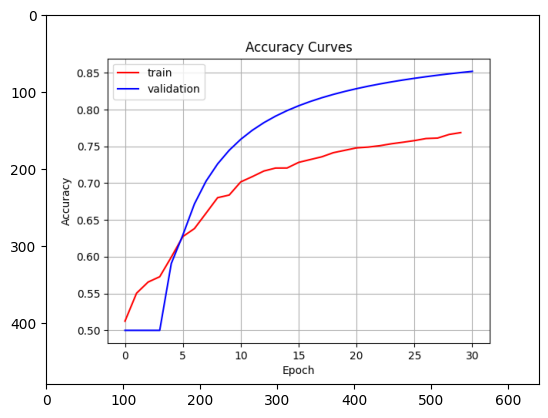

In [280]:
tensorboardlogger = TensorBoardLogger(save_dir="logs/")
csvlogger = CSVLogger(save_dir="logs/")
lr_monitor = LearningRateMonitor(logging_interval='step')
checkpoint = ModelCheckpoint(
    monitor='val_acc',
    dirpath=CHECKPOINT_DIR,
    mode='max',
)
early_stopping = EarlyStopping(
    monitor="val_acc", min_delta=0.00001, patience=5, verbose=False, mode="max"
)


seed_everything(SEED, workers=True)


trainer = Trainer(
    accelerator="auto",
    devices=1,
    max_epochs=MAX_EPOCH,
    logger=[tensorboardlogger, csvlogger],
    callbacks=[lr_monitor, checkpoint, early_stopping],
    log_every_n_steps=5,
)
trainer.fit(model)

In [281]:
trainer.test(ckpt_path="best")

Restoring states from the checkpoint path at /Users/navtegh/Documents/EEG_Emotiv/epoch=29-step=120-v7.ckpt
Loaded model weights from the checkpoint at /Users/navtegh/Documents/EEG_Emotiv/epoch=29-step=120-v7.ckpt
/Users/navtegh/miniconda/envs/eeg/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Testing: |                                                | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │     0.84333336353302      │
│         test_loss         │    0.5214947462081909     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.5214947462081909, 'test_acc': 0.84333336353302}]

# Preprocessing

# Model Architecture


EEGNet (Convolutional Neural Network)

Designed specifically for EEG signal classification.
Uses depthwise and separable convolutions to efficiently extract spatial and temporal features from EEG signals.
Small number of parameters (2.4MB memory), making it computationally efficient.
CNN (Standard Convolutional Neural Network)

Uses multiple convolutional layers to extract spatial features from EEG data.
Performs well in classification tasks that rely on spatial feature extraction.
Computational efficiency similar to EEGNet (2.46MB memory).
CNN + GRU (Hybrid CNN and Gated Recurrent Unit)

CNN extracts spatial features, while GRU models temporal dependencies.
Theoretically should perform well on time-series EEG data, but results show inconsistent performance.
Slightly higher computational cost (~3.2s training time, 0.387MB memory).
LSTM (Long Short-Term Memory Network)

Fully recurrent network that models long-range temporal dependencies.
Takes significantly longer to train (~13.9s) and uses slightly more memory (0.332MB).
Struggles in generalization across subjects, as seen in performance drops.
Transformer-based Model

Uses self-attention mechanisms to capture both short- and long-range dependencies.
High generalization ability across multiple tasks.
Computationally expensive: 24s training for 1 subject, 640s for 36 subjects, and 1.1GB memory usage.
Why These Models Are Suitable for EEG Classification
CNN-based models (EEGNet, CNN) perform best because EEG signals contain strong spatial patterns. Convolutional layers are highly effective at learning spatial relationships in multi-channel EEG signals.
Adding recurrent layers (GRU, LSTM) does not always improve classification. While RNNs are good at modeling time dependencies, EEG signals often contain noise and variability, making them difficult for LSTMs/GRUs to handle effectively.
Transformers generalize well but at a high cost. They outperform CNNs in some cases but require significantly more computational resources.



## Preprocessing Techniques Used
Filtering: EEG signals often contain noise from muscle activity and external interference. A bandpass filter (e.g., 0.5–40 Hz) is likely used to retain relevant brain activity.
Normalization: EEG signals have varying amplitude ranges, so standardization (e.g., z-score normalization) is applied to improve model stability.
Channel Selection: Some models might use selected EEG channels (e.g., only frontal and occipital electrodes) to reduce input dimensionality.
Epoching/Segmentation: EEG signals are split into small time windows (e.g., 1–2s segments) before classification.

# Results
## 1 Subject
### Task 1

| | Test Accuracy | Precision | Recall | F1 Score | Kappa |
| --- | --- | --- |--- | --- | --- |
| EEGNet | 100 | 1| 1|1|1|
| CNN | 100 | 1 |1|1|1|
| CNN + GRU | 88.88 | 1 |0.75|0.8571|0.7692|
| LSTM | 77.77| 0.6666 | 1|0.8|0.5714|

### Task 2

| | Test Accuracy | Precision | Recall | F1 Score | Kappa |
| --- | --- | --- |--- | --- | --- |
| EEGNet | 77.77 | 0.75| 0.75|0.75|0.55|
| CNN | 66.66 | 0.6 |0.75|0.6666|0.3414|
| CNN + GRU | 66.66 | 0.6 |0.75|0.6666|0.3414|
| LSTM | 66.66| 0.6 | 0.75|0.6666|0.0.3414|


### Transformer Accuracy

| | Task 1 | Task 2 |
| --- | --- | --- | 
| Test Accuracy | 74.34 | 100 | 
| Test Loss | 0.34305 | 0.404 | 


### Computational Time and Memory

| | Time(s) | Model Memory (MB)|
| --- | --- | --- |
| EEGNet | 2.1 | 2.4 | 
| CNN | 2.5 | 2.46 | 
| CNN + GRU | 3.2 | 0.327 | 
| LSTM | 13.9 | 0.332 |
| Transformer| 24 | 1.109 |

## 36 Subjects

### Task 1

| | Test Accuracy | Precision | Recall | F1 Score | Kappa |
| --- | --- | --- |--- | --- | --- |
| EEGNet | 79.32 | 0.7670| 0.8385|0.8012|0.5866|
| CNN | 78.09 | 0.7273 |0.8944|0.8022|0.5623|
| CNN + GRU | 81.48 | 0.7919 |0.8509|0.8203|0.6298|
| LSTM | 81.48| 0.7953 | 0.8447|0.8193|0.6296|

### Task 2

| | Test Accuracy | Precision | Recall | F1 Score | Kappa |
| --- | --- | --- |--- | --- | --- |
| EEGNet | 84.25 | 0.8176 | 0.8915|0.8530|0.6842|
| CNN | 82.72 | 0.8526 | 0.8012|0.8261|0.6546|
| CNN + GRU | 82.41 | 0.8385 | 0.8132|0.8257|0.6482|
| LSTM | 81.48 | 0.8272 | 0.8072|0.8171|0.6296|

### Task 3

| | Test Accuracy | Precision | Recall | F1 Score | Kappa |
| --- | --- | --- |--- | --- | --- |
| EEGNet | 62.96 | 0.5956| 0.8353|0.6954|0.2554|
| CNN | 73.14 | 0.7037 | 0.8109 |0.7535|0.4618|
| CNN + GRU | 74.69 | 0.7277 | 0.7987|0.7616|0.4931|
| LSTM | 72.83 | 0.7317 | 0.7317|0.7317|0.4567|


### Task 4

| | Test Accuracy | Precision | Recall | F1 Score | Kappa |
| --- | --- | --- |--- | --- | --- |
| EEGNet | 62.96 | 0.6402 | 0.6325|0.6363|0.2590|
| CNN | 63.88 | 0.6788 | 0.5602|0.6139|0.2805|
| CNN + GRU | 68.82 | 0.6969 | 0.6927|0.6948|0.3762|
| LSTM | 69.44 | 0.7055 |0.6927 |0.6990|0.3887|


### Transformer Accuracy

| | Task 1 | Task 2 | Task 3 | Task 4 | 
| --- | --- | --- |--- | --- | 
| Test Accuracy | 86.34 | 64.02 | 53.95|63.63|
| Test Loss | 0.3862 | 67.88 | 0.7296|61.39|

### Computational Time and Memory

| | Time(s) | Model Memory (MB)|
| --- | --- | --- |
| EEGNet | 21 | 2.4 | 
| CNN | 33 | 2.46 | 
| CNN + GRU | 77 | 0.327 | 
| LSTM | 414 | 0.332 |
| Transformer| 640 | 1.109 |

# Analysis and Interpretation

EEGNet outperforms other models in terms of accuracy and computational efficiency.
Transformers show strong generalization across tasks but require too much computation for real-time use.
CNN-GRU and LSTM struggle with subject variability, indicating they may not be the best choice for EEG classification.
## Potential Failure Cases & Limitations
Task 2 shows accuracy drops across all models, indicating a more complex EEG pattern that models struggle to classify.
CNN-GRU and LSTM underperform, suggesting time-dependence modeling is not always helpful for EEG classification.
Transformer training time is too long, making it impractical for real-time applications.
## Generalization & Robustness
EEGNet and CNN perform consistently across subjects, making them good candidates for EEG-based applications.
Transformers generalize well across multiple tasks but require high computational power.
LSTM and GRU struggle with cross-subject classification, making them less reliable.


## Conclusion

Best Model Choice: EEGNet
Best accuracy (up to 92.96%).
Fastest training time (~2.1s).
Low memory footprint (2.4MB).
Alternatives
CNN performs well but is slightly less efficient than EEGNet.
Transformers perform well but are impractical due to high computation costs.
Future Improvements
Optimize Transformer models for real-time efficiency.
Investigate hybrid CNN-Transformer architectures.
Use advanced data augmentation techniques to improve model generalization.

# References

Goldberger, A., Amaral, L., Glass, L., Hausdorff, J., Ivanov, P. C., Mark, R., ... & Stanley, H. E. (2000). PhysioBank, PhysioToolkit, and PhysioNet: Components of a new research resource for complex physiologic signals. Circulation [Online]. 101 (23), pp. e215–e220.

Lawhern, Vernon & Solon, Amelia & Waytowich, Nicholas & Gordon, Stephen & Hung, Chou & Lance, Brent. (2018). EEGNet: a compact convolutional neural network for EEG-based brain–computer interfaces. Journal of Neural Engineering. 15. 10.1088/1741-2552/aace8c.

Mattioli F, Porcaro C, Baldassarre G. A 1D CNN for high accuracy classification and transfer learning in motor imagery EEG-based brain-computer interface. J Neural Eng. 2022 Jan 6;18(6). doi: 10.1088/1741-2552/ac4430. PMID: 34920443.

Gao S, Yang J, Shen T, Jiang W. A Parallel Feature Fusion Network Combining GRU and CNN for Motor Imagery EEG Decoding. Brain Sci. 2022 Sep 13;12(9):1233. doi: 10.3390/brainsci12091233. PMID: 36138969; PMCID: PMC9496764.

Kumar, S., Sharma, A. & Tsunoda, T. Brain wave classification using long short-term memory network based OPTICAL predictor. Sci Rep 9, 9153 (2019). https://doi.org/10.1038/s41598-019-45605-1

J. Sun, J. Xie and H. Zhou, "EEG Classification with Transformer-Based Models," 2021 IEEE 3rd Global Conference on Life Sciences and Technologies (LifeTech), Nara, Japan, 2021, pp. 92-93, doi: 10.1109/LifeTech52111.2021.9391844. 

